In [173]:
import numpy as np
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import torchvision.transforms as transforms
import importlib
import os
import matplotlib.pyplot as plt


In [174]:
os.chdir("/Users/coulaud/Documents/DL-normalization")
os.getcwd()

'/Users/coulaud/Documents/DL-normalization'

In [175]:
ls results/wandb/cnn/nemo_valid/checkpoints

epoch=985-val_loss=0.00005.ckpt  last.ckpt


In [176]:
importlib.reload(cnn)
model = cnn.CNN.load_from_checkpoint("results/wandb/cnn/nemo_valid/checkpoints/epoch=985-val_loss=0.00005.ckpt")
data_dir = "data/processed/nemo_fixed/"

In [177]:
f = open(data_dir+"norms_std_mean.txt")
lines = f.readlines()
assert len(lines) == 2, f"len {len(lines)}"
std = float(lines[0])
mean = float(lines[1])
f.close()

In [178]:
X = np.load(data_dir+"train/X/NORSSH_PERTEN2.npz")['arr_0']
Y = np.load(data_dir+"train/Y/NORSSH_PERTEN2_norm_coeffs.npz")['arr_0']
X.shape, Y.shape

((3, 352, 416), (352, 416))

### Bias on 1 sample

In [179]:
X = np.load(data_dir+"train/X/NORSSH_PERTEN2.npz")['arr_0']
Y = np.load(data_dir+"train/Y/NORSSH_PERTEN2_norm_coeffs.npz")['arr_0']
Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
mask = np.where(Y==0,True,False)
Y = Y*std + mean
X = torch.from_numpy(X[np.newaxis,:]).float()
X = transforms.CenterCrop([310, 380])(X)

In [180]:
Y_pred = model.forward(X).detach()[0,0,:,:]*std + mean
#Y_pred =  transforms.CenterCrop([290, 360])(Y_pred).numpy()[0,0,:,:]
Y2 = np.power(Y,2)
eps = (np.power(Y_pred,2) - Y2)/Y2
eps = np.ma.masked_array(eps, mask)

print("mean: ",np.mean(np.abs(eps)[np
                                   .nonzero(eps)]))
print("max: ",np.max(eps))
print("min: ",np.min(eps))

mean:  0.0016145691170813578
max:  0.04974074750943201
min:  -0.04214622850890724


In [181]:
Y_pred.shape

torch.Size([290, 360])

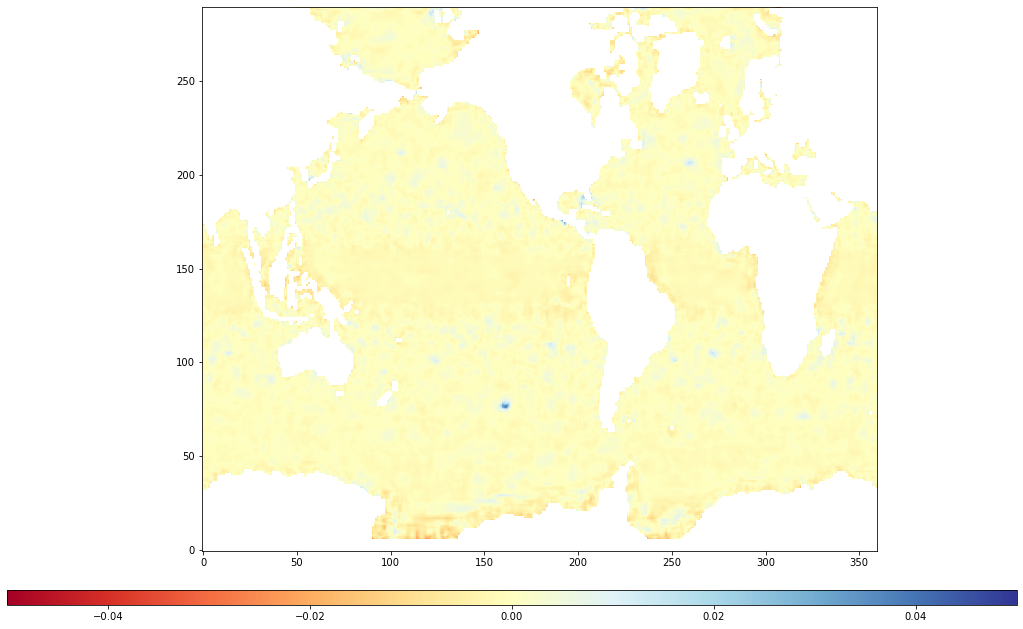

In [182]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

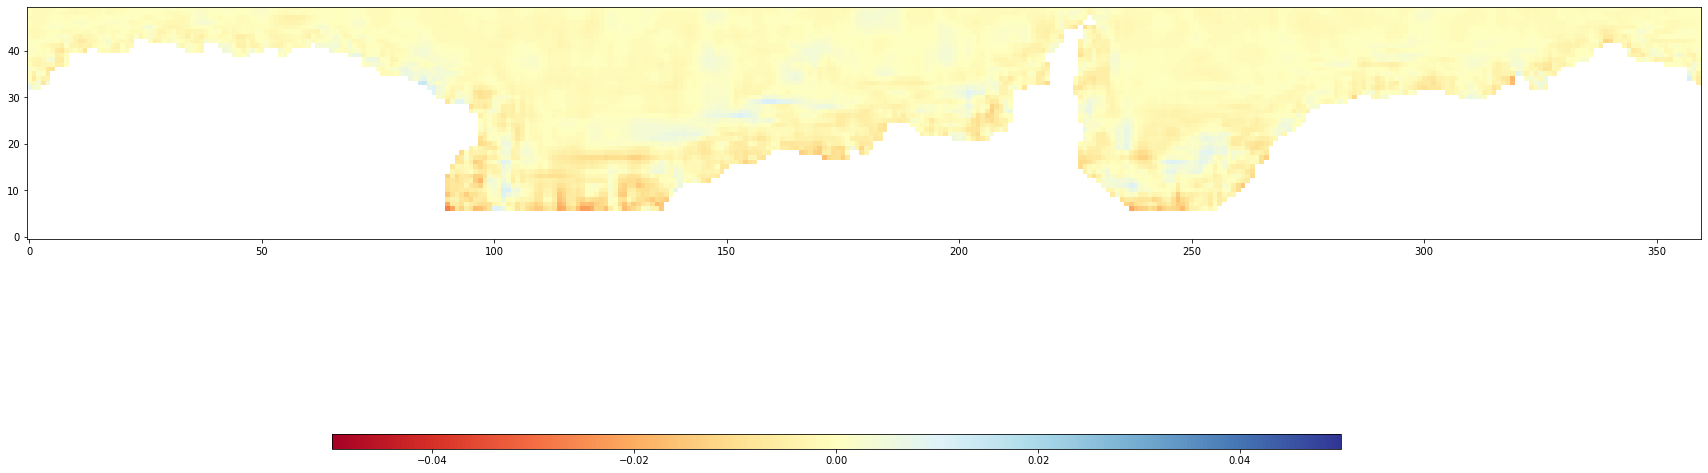

In [183]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[0:50,:],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

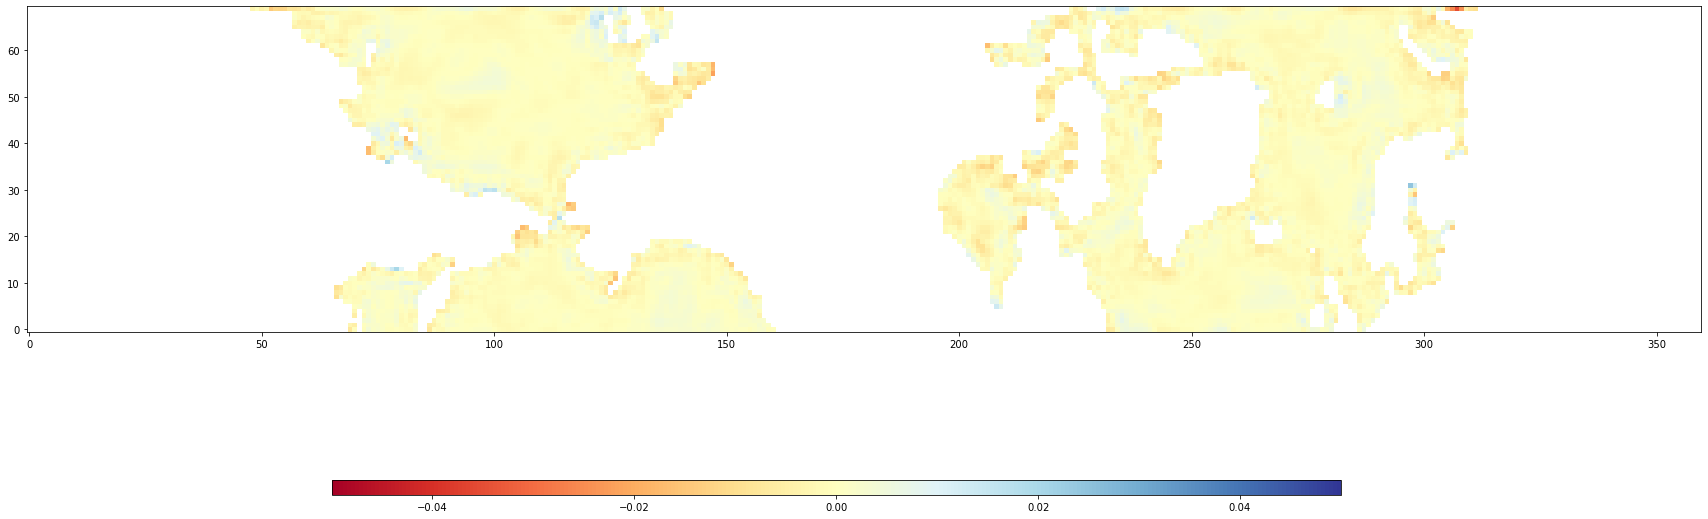

In [184]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[220:290,:],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

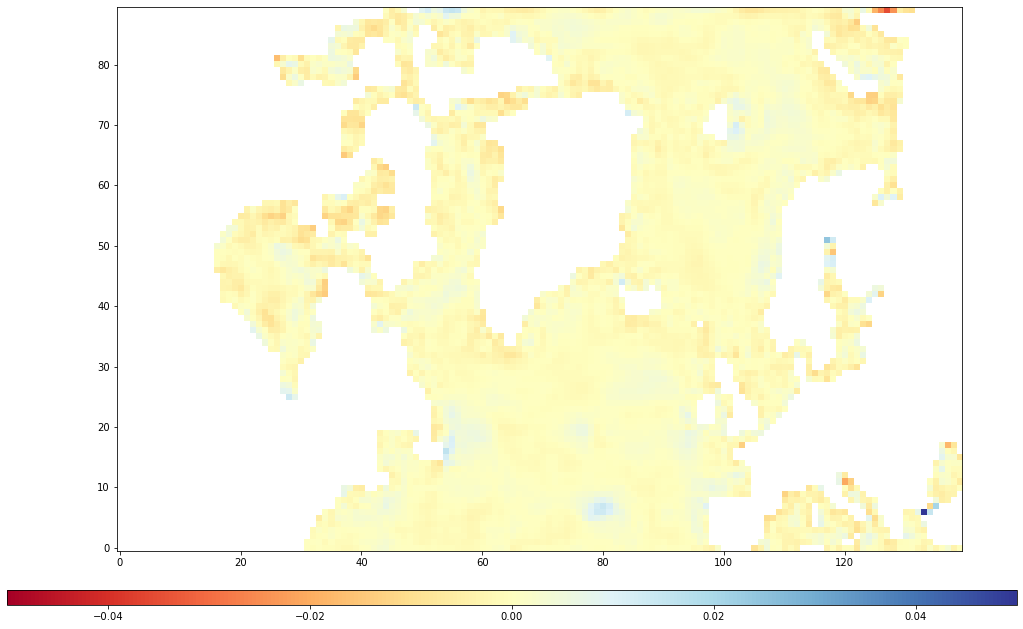

max:  0.04974074750943201
min:  -0.03509867982219644


In [185]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[200:290,180:320],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
print("max: ",np.max(eps[200:290,180:320]))
print("min: ",np.min(eps[200:290,180:320]))

### Plot MSE

In [186]:
eps = np.square(Y_pred-Y)
eps = np.ma.masked_array(eps, mask)

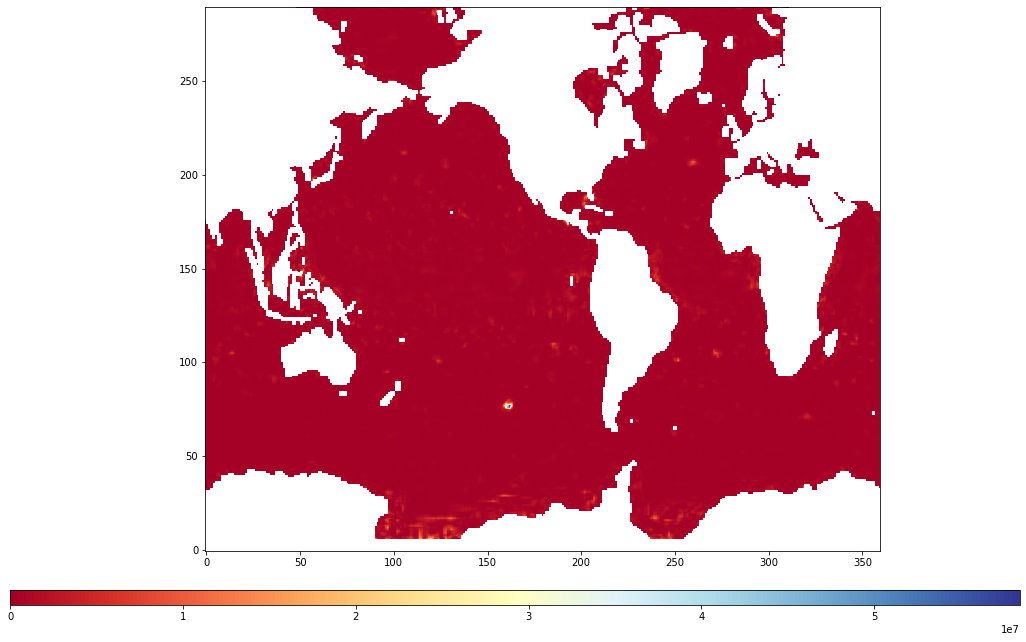

mean:  311369.20855352667
max:  58436766.12185554
min:  4.19100205477905e-08


In [187]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps,origin="lower",vmin=np.min(eps),vmax=np.max(eps),cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
print("mean: ",np.mean(np.abs(eps)[np.nonzero(eps)]))
print("max: ",np.max(eps))
print("min: ",np.min(eps))

In [188]:
eps1 = np.ma.masked_array(eps, np.where(np.abs(eps)<np.max(eps)/40,True,False))

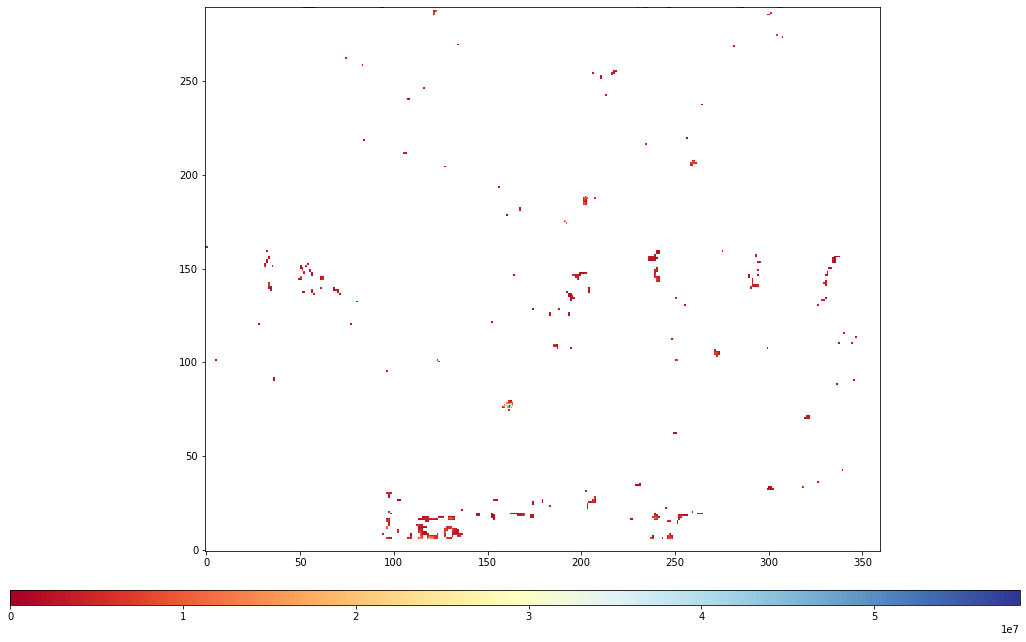

In [189]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps1,origin="lower",vmin=np.min(eps),vmax=np.max(eps),cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

### Training bias

In [190]:
epsF = np.empty((len(os.listdir(data_dir+"train/X/")),290,360))
for i,file_list in enumerate(os.listdir(data_dir+"train/X/")):
    X=np.load(data_dir+"train/X/"+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = transforms.CenterCrop([310, 380])(X)
    Y=np.load(data_dir+"train/Y/"+ file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
    if i==0:
        mask = np.where(Y==0,True,False) 
    Y = Y*std + mean
    Y_pred = model.forward(X).detach()*std + mean
    aux = (Y_pred**2 - Y**2)/Y**2
    epsF[i,:,:] = np.ma.masked_array(aux, mask)
    
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(epsF,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.max(epsF,axis=0), mask))))
print("mean max: ",np.mean(np.abs(np.ma.masked_array(np.max(epsF,axis=0), mask))))

mean:  0.0008149003398920725
max:  0.12534199710198576
mean max:  0.006278152773592733


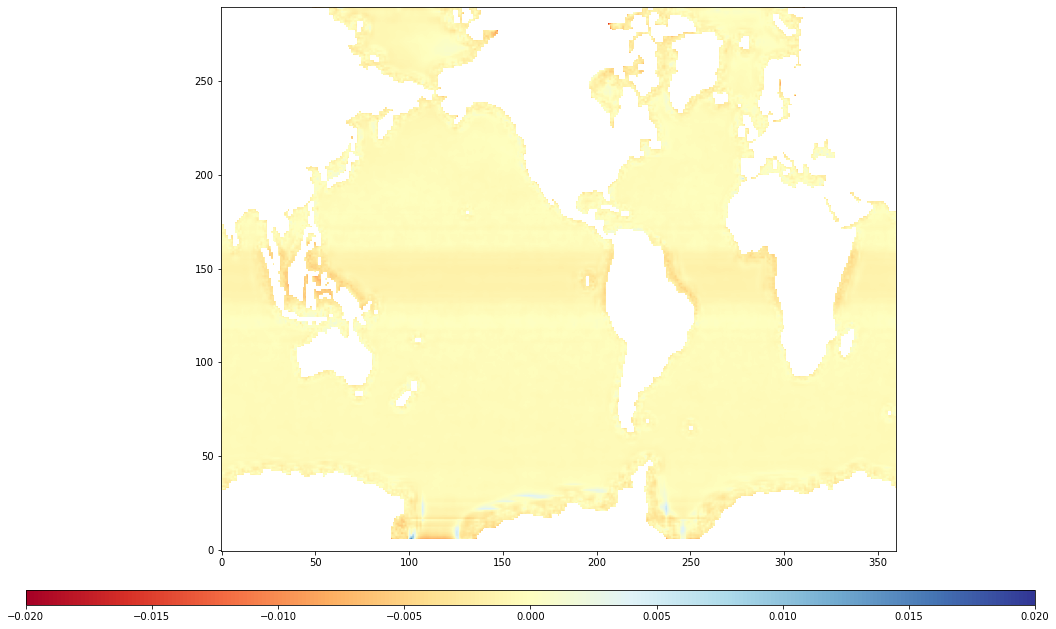

In [191]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(np.mean(epsF,axis=0), mask),origin="lower",vmin=-0.02,vmax=0.02,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

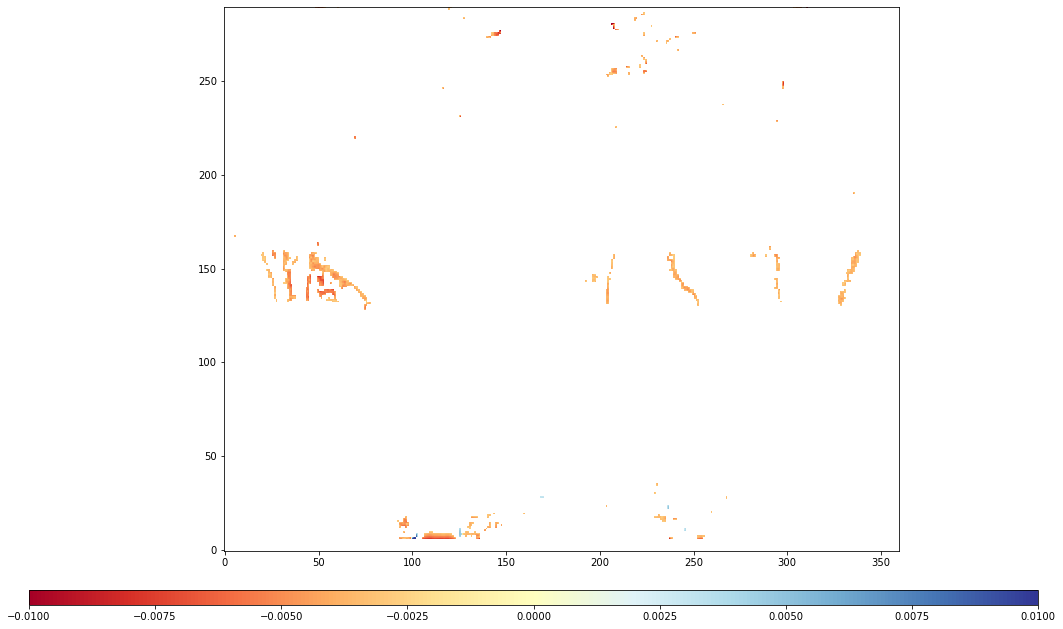

In [192]:
map1 = np.ma.masked_array(np.mean(epsF,axis=0), mask)
map2 = np.ma.masked_array(map1, np.where(np.abs(map1) < np.max(np.abs(map1))/10,True,False))
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(map2,origin="lower",vmin=-0.01,vmax=0.01,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

### Validation bias

In [193]:
epsV = np.empty((len(os.listdir(data_dir+"valid/X/")),290,360))
for i,file_list in enumerate(os.listdir(data_dir+"valid/X/")):
    X=np.load(data_dir+"valid/X/"+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = transforms.CenterCrop([310, 380])(X)
    Y=np.load(data_dir+"valid/Y/"+ file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
    if i==0:
        mask = np.where(Y==0,True,False) 
    Y = Y*std + mean
    Y_pred = model.forward(X).detach()*std + mean
    aux = (Y_pred**2 - Y**2)/(Y**2)
    epsV[i,:,:] = np.ma.masked_array(aux, mask)
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(epsV,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.max(epsV,axis=0), mask))))
print("mean max: ",np.mean(np.abs(np.ma.masked_array(np.max(epsV,axis=0), mask))))

mean:  0.001205908877048069
max:  0.17499863688553374
mean max:  0.0025910041648091898


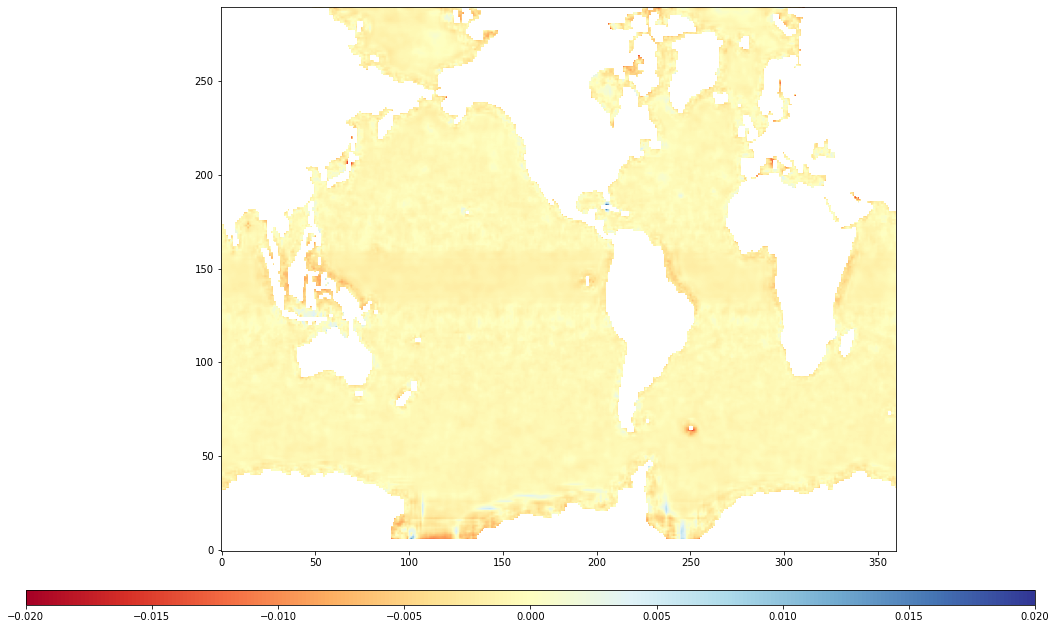

In [194]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(np.mean(epsV,axis=0), mask),origin="lower",vmin=-0.02,vmax=0.02,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

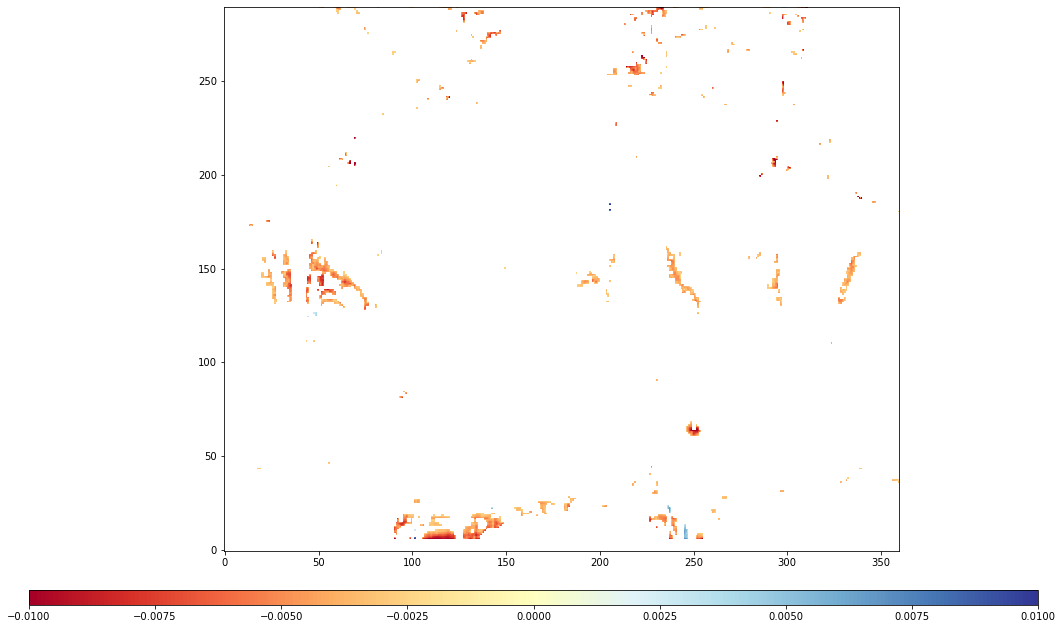

In [195]:
map1 = np.ma.masked_array(np.mean(epsV,axis=0), mask)
map2 = np.ma.masked_array(map1, np.where(np.abs(map1) < np.max(np.abs(map1))/10,True,False))
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(map2,origin="lower",vmin=-0.01,vmax=0.01,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

### Predicted value

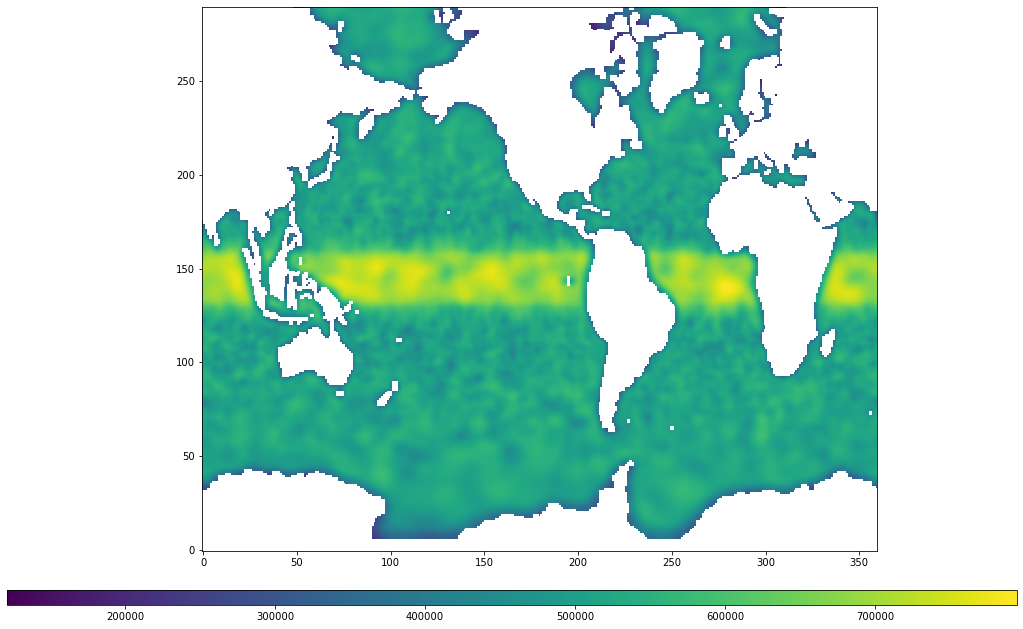

In [196]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(Y_pred, mask)[0,0,:,:],origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

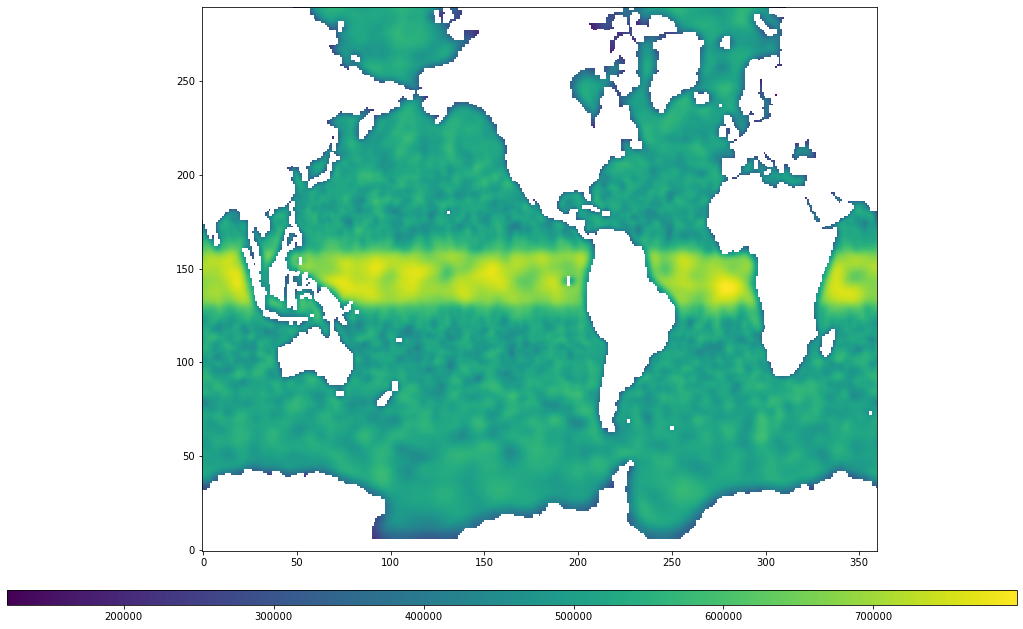

In [197]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(Y, mask),origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

torch.Size([1, 3, 290, 360])


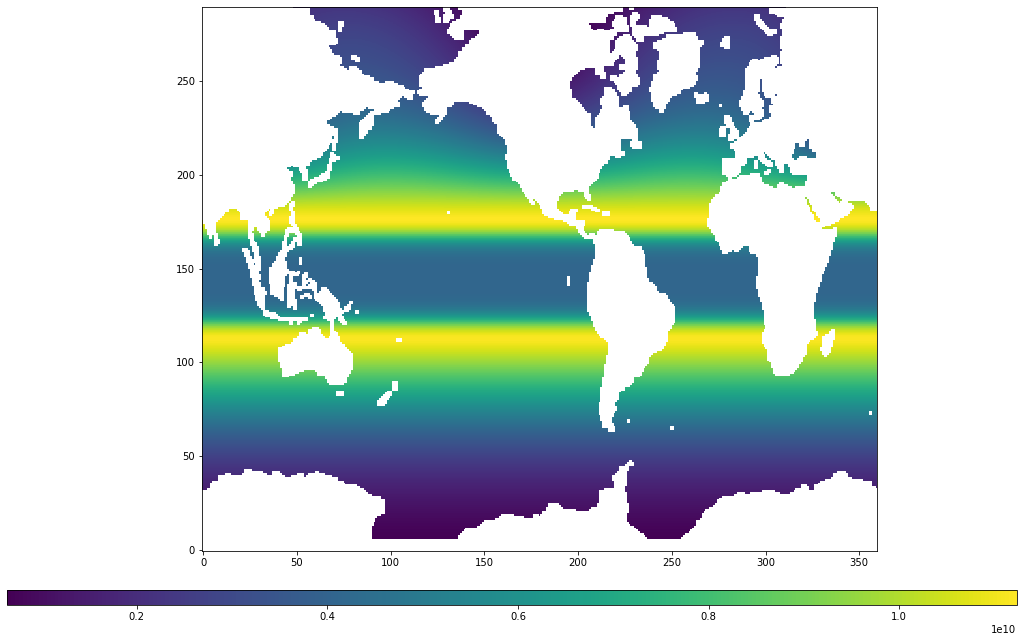

In [218]:
X = np.load(data_dir+"train/X/NORSSH_PERTEN2.npz")['arr_0']
X = torch.from_numpy(X[np.newaxis,:]).float()
X = transforms.CenterCrop([290, 360])(X)
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(X[0,2,:,:]*3179753752.515214+4834679434.517039, mask),origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

torch.Size([1, 3, 290, 360])


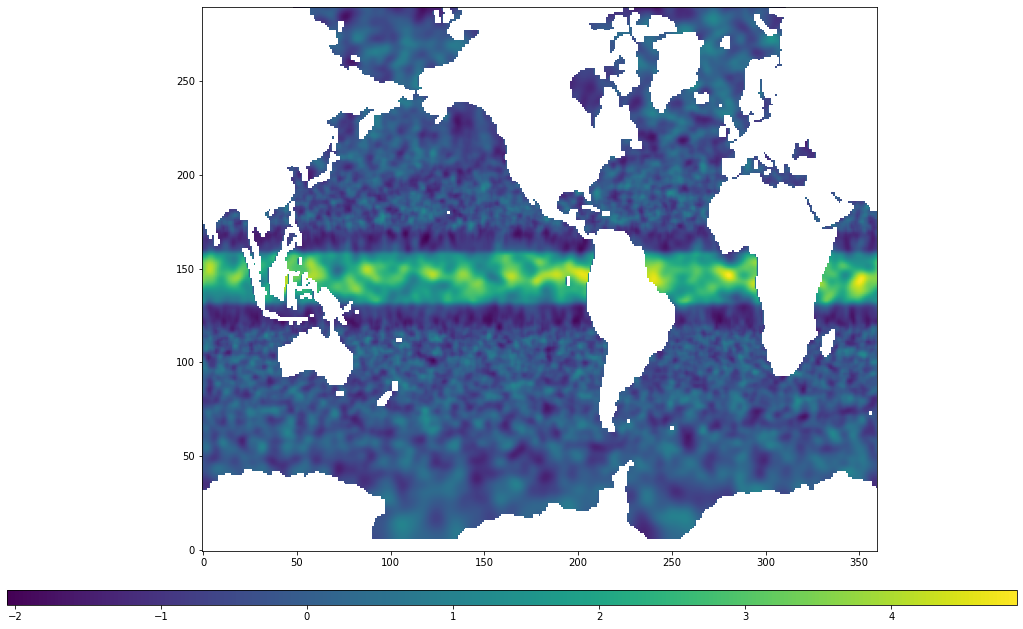

In [211]:
X = np.load(data_dir+"train/X/NORSSH_PERTEN2.npz")['arr_0']
X = torch.from_numpy(X[np.newaxis,:]).float()
X = transforms.CenterCrop([290, 360])(X)
print(X.shape)
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(X[0,1,:,:], mask),origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()